# Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


In [2]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance "classes"
erosion_width = 0  # erode edges

In [29]:
npz_name = "Point1_12_18_3X_interior_border_border.npz"
fgbg_model_name = 'sample_fgbg_Point1_12_18_23_interior_border_border_5'
sample_model_name = 'sample_watershed_Point1_12_18_23_interior_border_border_20'

### Load the Training Data

In [19]:
CHANNEL_AXIS = 3
training_data = np.load(os.path.join('/notebooks/Noah_Scripts/notebooks/output/npz_data', npz_name))

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

X.shape: (3, 1024, 1024, 3) & y.shape: (3, 1024, 1024, 1)


### Set up filepath constants

In [20]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.join(os.getcwd(), "output/npz_data")

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, npz_name)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [6]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/notebooks/Noah_Scripts/notebooks/output/'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [21]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    n_channels=X.shape[CHANNEL_AXIS],
    n_features=2)

#### Train the fgbg model

In [22]:
from deepcell.training import train_model_sample

fgbg_model = train_model_sample(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    test_size=test_size,
    optimizer=optimizer,
    window_size=(win, win),
    batch_size=batch_size,
    transform='fgbg',
    n_epoch=5,
    balance_classes=balance_classes,
    max_class_samples=max_class_samples,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),
    test_split=False)

using all data as training data
X_train shape: (3, 1024, 1024, 3)
y_train shape: (3, 1024, 1024, 1)
Output Shape: (None, 2)
Number of Classes: 2
Training on 1 GPUs
running model without validation checks
Epoch 1/5
28661/28661 [==============================] - 2603s 91ms/step - loss: 0.2127 - acc: 0.9098
Epoch 2/5
28661/28661 [==============================] - 2594s 91ms/step - loss: 0.2028 - acc: 0.9135
Epoch 3/5
28661/28661 [==============================] - 2598s 91ms/step - loss: 0.1978 - acc: 0.9154
Epoch 4/5
28661/28661 [==============================] - 2550s 89ms/step - loss: 0.1939 - acc: 0.9170
Epoch 5/5
28661/28661 [==============================] - 2563s 89ms/step - loss: 0.1908 - acc: 0.9181


### Next, Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [23]:
from deepcell import model_zoo
from deepcell.training import train_model_sample

watershed_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    n_channels=X.shape[CHANNEL_AXIS],
    n_features=distance_bins)

#### Train the model

In [30]:
watershed_model = train_model_sample(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=sample_model_name,
    test_size=test_size,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=10,
    window_size=(win, win),
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    balance_classes=balance_classes,
    max_class_samples=max_class_samples,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),
    test_split=False)

using all data as training data
X_train shape: (3, 1024, 1024, 3)
y_train shape: (3, 1024, 1024, 1)
Output Shape: (None, 4)
Number of Classes: 4
Training on 1 GPUs
running model without validation checks
Epoch 1/10
6382/6382 [==============================] - 591s 93ms/step - loss: 0.6709 - acc: 0.6741
Epoch 2/10
6382/6382 [==============================] - 583s 91ms/step - loss: 0.6621 - acc: 0.6807
Epoch 3/10
6382/6382 [==============================] - 582s 91ms/step - loss: 0.6396 - acc: 0.6937
Epoch 4/10
6382/6382 [==============================] - 579s 91ms/step - loss: 0.6187 - acc: 0.7066
Epoch 5/10
6382/6382 [==============================] - 583s 91ms/step - loss: 0.6052 - acc: 0.7143
Epoch 6/10
6382/6382 [==============================] - 580s 91ms/step - loss: 0.5947 - acc: 0.7204
Epoch 7/10
6382/6382 [==============================] - 591s 93ms/step - loss: 0.5863 - acc: 0.7251
Epoch 8/10
6382/6382 [==============================] - 591s 93ms/step - loss: 0.5799 - acc: 0.7

In [31]:
fgbg_model_name
sample_model_name

'sample_watershed_Point1_12_18_23_interior_border_border_20'

### Run the model

The model was trained on small samples of data of shape `(receptive_field, receptive_field)`.
in order to process full-sized images, the trained weights will be saved and loaded into a new model with `dilated=True` and proper `input_shape`.

#### Save weights of trained models

In [32]:
# Save the model weights to reload a dilated model

# fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
# fgbg_model.save_weights(fgbg_weights_file)

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(sample_model_name))
watershed_model.save_weights(watershed_weights_file)

#### Initialize dilated models and load the weights

In [31]:
from deepcell import model_zoo

# All training parameters should match except for the `input_shape` and `dilated=True`

run_fgbg_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=2,
    input_shape=tuple(X.shape[1:]))
run_fgbg_model.load_weights(fgbg_weights_file)

run_watershed_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    receptive_field=receptive_field,
    n_features=distance_bins,
    input_shape=tuple(X.shape[1:]))
run_watershed_model.load_weights(watershed_weights_file)

#### Make predictions on test data

In [32]:
# With the trained model, make predictions on testing data
test_images = run_watershed_model.predict(X)
test_images_fgbg = run_fgbg_model.predict(X)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (4, 1024, 1024, 4)
segmentation mask shape: (4, 1024, 1024, 2)


#### Watershed post-processing

In [33]:
argmax_images = []
for i in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[i], axis=-1))
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (4, 1024, 1024, 1)


In [34]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [50]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1],
                                min_distance=5, 
                                exclude_border=False,
                                indices=False,
                                labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

In [40]:
argmax_images.shape

(4, 1024, 1024, 1)

### Plot the Results

Image number: 3


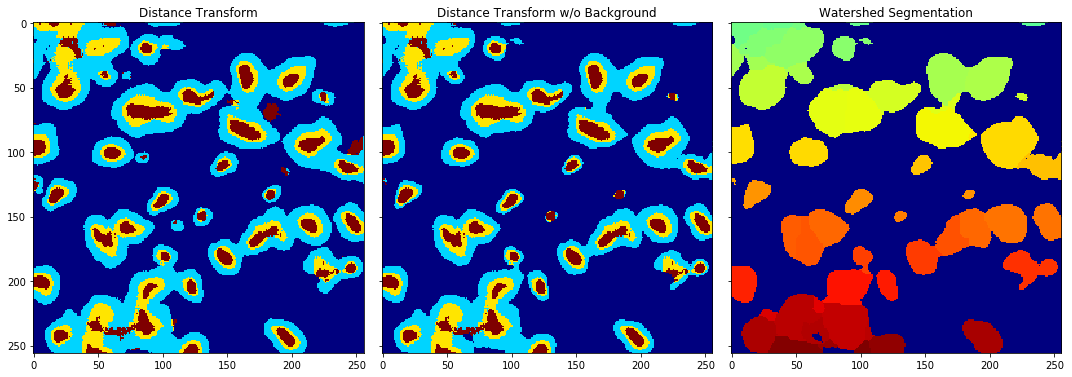

In [51]:
import matplotlib.pyplot as plt

index = 3 #np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

# fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

# ax[0].imshow(X[index, ..., 0])
# ax[0].set_title('Source Image')

# ax[1].imshow(test_images_fgbg[index, ..., 1])
# ax[1].set_title('Segmentation Prediction')

# ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
# ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[0].imshow(argmax_images[index, 256:512, 256:512, 0], cmap='jet')
ax[0].set_title('Distance Transform')

ax[1].imshow(argmax_images_post_fgbg[index, 256:512, 256:512, 0], cmap='jet')
ax[1].set_title('Distance Transform w/o Background')

ax[2].imshow(watershed_images[index, 256:512, 256:512, 0], cmap='jet')
ax[2].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()